# ADHD Dectection
[INTRODUCTION OF THE PROBLEM HERE]

## Dataset:
[ADD AND COMMENT ABOUT DATASETS HERE]

## Task:
[ADD TASK HERE]

## Integrants:
Name, Matricola, Email

- Jan Elfes, 2040496, jan.elfes@studenti.unipd.it

- Santiago Víquez Segura, 2048722, santiago.viquezsegura@studenti.unipd.it


## Dependencies

In [1]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import nibabel as nib
import pandas as pd
from config_local import helpers

from sklearn.linear_model import Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

hp = helpers()

In [2]:
_data_path = hp.get_data_path()
print(_data_path)

/media/jan/TOSHIBA EXT/SMHDD_22/data/


## Baseline

Before working with the FMRI data we will fit a logistic regression classifier on the phenotypic tabular data to come up with a baseline. We expect that any experiment using the FMRI data outperforms the following result.

In [3]:
phenotypic_df = pd.read_csv(_data_path + "NYU_phenotypic.csv")
phenotypic_df.head()

,ScanDir ID,Site,Gender,Age,Handedness,DX,Secondary Dx,ADHD Measure,ADHD Index,Inattentive,...,Full4 IQ,Med Status,QC_Rest_1,QC_Rest_2,QC_Rest_3,QC_Rest_4,QC_Anatomical_1,QC_Anatomical_2,Fold,Partition
0,1000804,5,1.0,7.29,0.83,0,NaN,2,40,41,...,109,1,1.0,0.0,NaN,NaN,1.0,NaN,4.0,train
1,1023964,5,1.0,8.29,0.57,3,NaN,2,60,56,...,123,-999,1.0,0.0,NaN,NaN,1.0,1.0,3.0,train
2,1057962,5,1.0,8.78,-999.00,1,NaN,2,77,81,...,129,1,1.0,NaN,NaN,NaN,1.0,0.0,1.0,train
3,1099481,5,0.0,8.04,0.50,1,NaN,2,86,82,...,116,1,1.0,0.0,NaN,NaN,1.0,1.0,2.0,train
4,1127915,5,0.0,12.44,0.21,0,NaN,2,42,43,...,124,1,1.0,1.0,NaN,NaN,1.0,1.0,4.0,train


We are going to use `"Gender", "ADHD Index", "Age", "Handedness", "Inattentive", "Hyper/Impulsive", "Verbal IQ","Performance IQ", "Full4 IQ", "Med Status", "QC_Rest_1", "QC_Rest_2", "QC_Anatomical_1", "QC_Anatomical_2"` as predictors and use the token `-999` to fill and recognize NaN values.

In [4]:
features = ["Gender", "ADHD Index", "Age", "Handedness", 
            "Inattentive", "Hyper/Impulsive", "Verbal IQ",
           "Performance IQ", "Full4 IQ", "Med Status",
            "QC_Rest_1", "QC_Rest_2", "QC_Anatomical_1", 
            "QC_Anatomical_2"]

phenotypic_df = phenotypic_df[features + ["DX", "Fold", "Partition"]].fillna(-999)

In [5]:
train_df = phenotypic_df[phenotypic_df["Partition"] == "train"]
test_df = phenotypic_df[phenotypic_df["Partition"] == "test"]
scores = []

for fold in range(1, 6):
    X_train = train_df[train_df["Fold"] != fold][features]
    y_train = train_df[train_df["Fold"] != fold]["DX"]
    
    X_val = train_df[train_df["Fold"] == fold][features]
    y_val = train_df[train_df["Fold"] == fold]["DX"]
    
    clf = LogisticRegression(max_iter=7000,
                         solver="saga",
                         penalty=None,
                         random_state=42).fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    
    score = f1_score(y_val, y_pred, average="weighted")
    scores.append(score)
    print(f"Fold {fold} -- f1-Score (val): {score}")
print(f"\nAverage f1-Score (val): {np.mean(scores)}")

Fold 1 -- f1-Score (val): 0.544041184041184
Fold 2 -- f1-Score (val): 0.8856209150326796
Fold 3 -- f1-Score (val): 0.7632043808514397
Fold 4 -- f1-Score (val): 0.7854291037682042
Fold 5 -- f1-Score (val): 0.691800356506239

Average f1-Score (val): 0.7340191880399494


# Lasso

As first model we will use a simple Lasso regression for the fMRI data. 

In [4]:
phenotypic_df = pd.read_csv(_data_path + "NYU_phenotypic.csv").fillna(-999)
dic = {}

for i, row in phenotypic_df.iterrows():
    
    id = str(row['ScanDir ID']).zfill(7)
    fold = int(row['Fold'])
    part = row['Partition']

    if fold != -999:
        file = _data_path + f"{part}/fold{fold}/wmean_mrda{id}_session_1_rest_1.nii.gz"
        img = nib.load(file)
        data = img.get_fdata()
        y = row['DX']
        y_bin = int(y>=1)
        dic[id] = {"img":img, "data":data, "dx":y, "dx_bin":y_bin, "part":part, "fold":fold}
    
    

In [5]:
def train_loader(dic, i):
    X_val = []
    X_train = []
    y_val = []
    y_train = []

    for id, subj in dic.items():

        if ((subj["part"]=="train") & (subj["fold"]==i)):
            X_val.append(subj['data'].reshape(-1))
            y_val.append(subj['dx_bin'])
        
        if ((subj["part"]=="train") & (subj["fold"]!=i)):
            X_train.append(subj['data'].reshape(-1))
            y_train.append(subj['dx_bin'])
    
    return np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val)

In [6]:
# Create X and y array
for i in range(1, 6):
    X_train, y_train, X_val, y_val = train_loader(dic, i)
    print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(136, 133574) (136,) (35, 133574) (35,)
(137, 133574) (137,) (34, 133574) (34,)
(137, 133574) (137,) (34, 133574) (34,)
(137, 133574) (137,) (34, 133574) (34,)
(137, 133574) (137,) (34, 133574) (34,)


In [21]:
scores = []

for fold in range(1, 6):

    X_train, y_train, X_val, y_val = train_loader(dic, fold)

    clf = Lasso(alpha=0.01,
                random_state=42,
                max_iter=7000).fit(X_train, y_train)
    y_pred = np.round(clf.predict(X_val))
    
    score = f1_score(y_val, y_pred, average="weighted")
    scores.append(score)
    print(f"Fold {fold} -- f1-Score (val): {score}")
print(f"\nAverage f1-Score (val): {np.mean(scores)}")

Fold 1 -- f1-Score (val): 0.5413632119514472
Fold 2 -- f1-Score (val): 0.6470588235294118
Fold 3 -- f1-Score (val): 0.6470588235294118
Fold 4 -- f1-Score (val): 0.6803884780929257
Fold 5 -- f1-Score (val): 0.5013077593722755

Average f1-Score (val): 0.6034354192950944


## Model selection Lasso

In [34]:
from sklearn.metrics import mean_squared_error

In [56]:
clf = Lasso(alpha=10,
        random_state=42,
        max_iter=7000).fit(X_train, y_train)


In [57]:
cv_lambda = np.logspace(-8, 2, 40)
coefs = []
f1_scores = []
f1_scores_mean = []
mse_scores = []
mse_scores_mean = []

for lam in cv_lambda:
    for fold in range(1, 6):

        X_train, y_train, X_val, y_val = train_loader(dic, fold)

        clf = Lasso(alpha=lam,
                    random_state=42,
                    max_iter=7000).fit(X_train, y_train)
        y_pred = np.round(clf.predict(X_val))
        
        score = f1_score(y_val, y_pred, average="weighted")
        mse = mean_squared_error(y_val, y_pred)

        f1_scores.append(score)
        mse_scores.append(mse)
        coefs.append(clf.coef_)

    f1_scores_mean.append(np.mean(f1_scores[-5:]))
    mse_scores_mean.append(np.mean(mse_scores[-5:]))

    print(f"\n Lambda = {np.round(lam, 4)}  \tAverage f1-Score (val): {f1_scores_mean[-1]}\n \t\t\tMean Squared Error: \t{mse_scores_mean[-1]}")


 Lambda = 0.0  	Average f1-Score (val): 0.4867843891810383
 			Mean Squared Error: 	175.50840336134453

 Lambda = 0.0  	Average f1-Score (val): 0.48036904835079286
 			Mean Squared Error: 	80.35008403361344

 Lambda = 0.0  	Average f1-Score (val): 0.47317833439682183
 			Mean Squared Error: 	7.906050420168067

 Lambda = 0.0  	Average f1-Score (val): 0.46717237645809073
 			Mean Squared Error: 	4.087731092436975

 Lambda = 0.0  	Average f1-Score (val): 0.48880229014682797
 			Mean Squared Error: 	2.466554621848739

 Lambda = 0.0  	Average f1-Score (val): 0.485031201669857
 			Mean Squared Error: 	1.9680672268907564

 Lambda = 0.0  	Average f1-Score (val): 0.481289019263239
 			Mean Squared Error: 	1.0235294117647058

 Lambda = 0.0  	Average f1-Score (val): 0.4824428155412723
 			Mean Squared Error: 	0.6368067226890757

 Lambda = 0.0  	Average f1-Score (val): 0.49926865670793213
 			Mean Squared Error: 	0.6126050420168067

 Lambda = 0.0  	Average f1-Score (val): 0.4965117286226186
 			M

/home/jan/ds/3rd-semester/Stat/project/stat-venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.430e-03, tolerance: 3.403e-03
  model = cd_fast.enet_coordinate_descent(



 Lambda = 0.0002  	Average f1-Score (val): 0.5813843889248886
 			Mean Squared Error: 	0.41529411764705887


/home/jan/ds/3rd-semester/Stat/project/stat-venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.477e-03, tolerance: 3.394e-03
  model = cd_fast.enet_coordinate_descent(



 Lambda = 0.0004  	Average f1-Score (val): 0.593326989670046
 			Mean Squared Error: 	0.40352941176470586


/home/jan/ds/3rd-semester/Stat/project/stat-venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.933e-03, tolerance: 3.403e-03
  model = cd_fast.enet_coordinate_descent(
/home/jan/ds/3rd-semester/Stat/project/stat-venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.806e-03, tolerance: 3.403e-03
  model = cd_fast.enet_coordinate_descent(



 Lambda = 0.0007  	Average f1-Score (val): 0.5654929171846773
 			Mean Squared Error: 	0.4495798319327731


/home/jan/ds/3rd-semester/Stat/project/stat-venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.601e-03, tolerance: 3.403e-03
  model = cd_fast.enet_coordinate_descent(



 Lambda = 0.0013  	Average f1-Score (val): 0.5993318466590356
 			Mean Squared Error: 	0.42033613445378154

 Lambda = 0.0024  	Average f1-Score (val): 0.5868312546319012
 			Mean Squared Error: 	0.43210084033613444

 Lambda = 0.0044  	Average f1-Score (val): 0.6034354192950944
 			Mean Squared Error: 	0.3973109243697479

 Lambda = 0.0079  	Average f1-Score (val): 0.6034354192950944
 			Mean Squared Error: 	0.3973109243697479

 Lambda = 0.0143  	Average f1-Score (val): 0.5978805994935027
 			Mean Squared Error: 	0.40319327731092436

 Lambda = 0.0257  	Average f1-Score (val): 0.6102693385046326
 			Mean Squared Error: 	0.39142857142857146

 Lambda = 0.0464  	Average f1-Score (val): 0.6041869753065198
 			Mean Squared Error: 	0.3973109243697479

 Lambda = 0.0838  	Average f1-Score (val): 0.6159824519976322
 			Mean Squared Error: 	0.3855462184873949

 Lambda = 0.1512  	Average f1-Score (val): 0.6035982685091771
 			Mean Squared Error: 	0.39714285714285713

 Lambda = 0.2728  	Average f1-S

TODO: need to implement AIC/BIC for model selection. For Lasso in sklearn this seems to be `LassoLarsIC` but did not make it work yet.

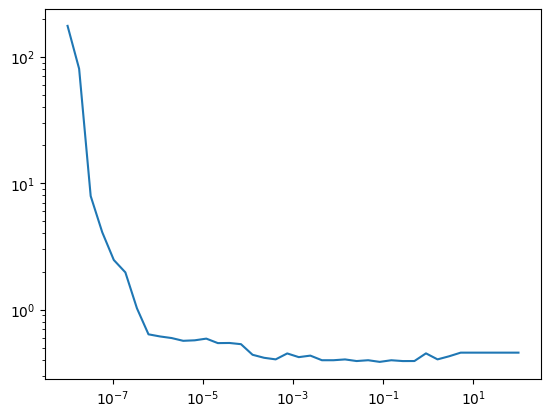

In [60]:
plt.plot(cv_lambda ,mse_scores_mean)
plt.xscale('log')
plt.yscale('log')

In [123]:
len(mse_scores_mean)

40

Lambda with minimal mse: λ = 0.08377
Respective f1-score:	f1 = 0.47


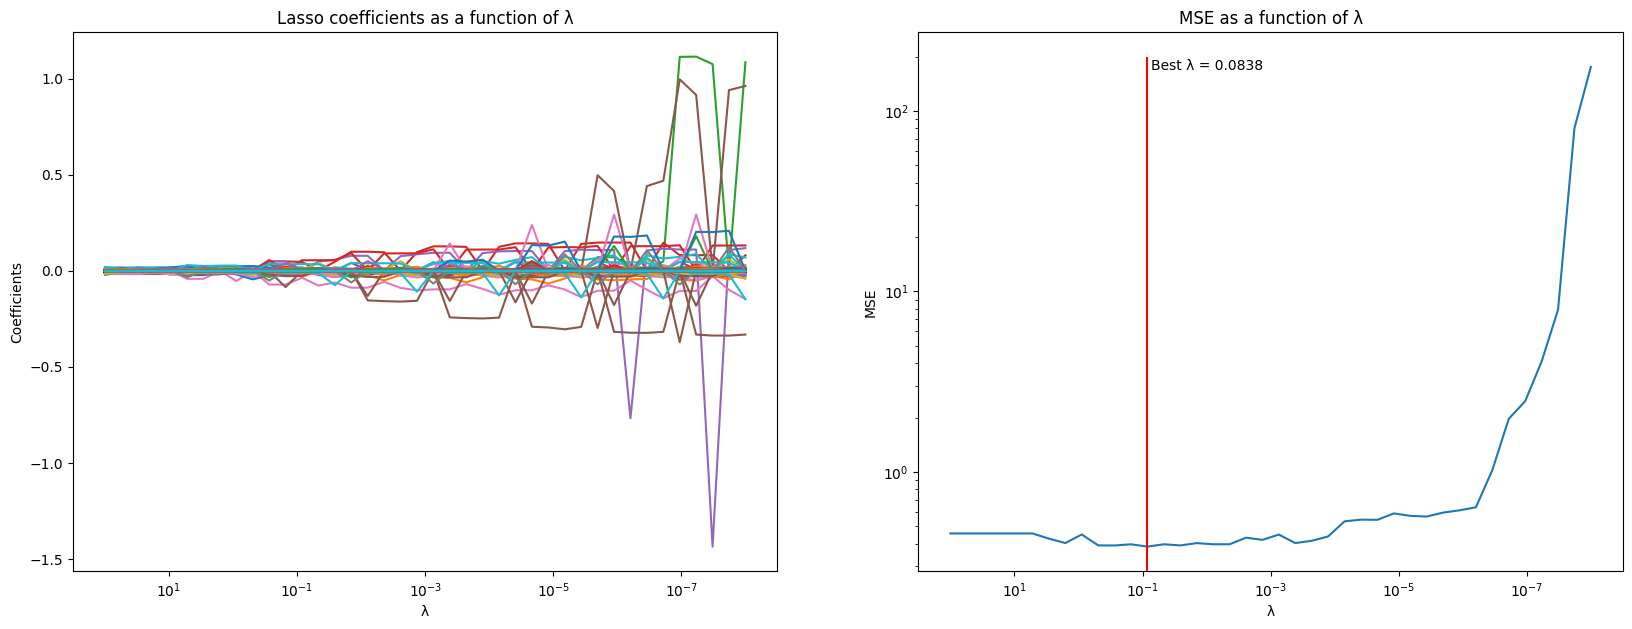

In [143]:
best_index = np.argmin(mse_scores_mean)
print(f"Lambda with minimal mse: \u03BB = {np.round(cv_lambda[best_index], 5)}")
print(f"Respective f1-score:\tf1 = {np.round(f1_scores[best_index], 2)}")

mean_coefs = np.array(coefs).reshape(5, 40, len(coefs[0])).mean(axis=0)

fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].plot(cv_lambda, mean_coefs[:, 9000:10000])
ax[0].set_xscale('log')
ax[0].axis('tight')
ax[0].invert_xaxis()
ax[0].set_xlabel('\u03BB')
ax[0].set_ylabel('Coefficients')
ax[0].set_title('Lasso coefficients as a function of \u03BB')

ax[1].plot(cv_lambda, mse_scores_mean)
ax[1].vlines(x=cv_lambda[best_index], ymin=0, ymax=200, color="red")
ax[1].text(cv_lambda[best_index]-0.01, 170, f"Best \u03BB = {np.round(cv_lambda[best_index], 4)}")
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].axis('tight')
ax[1].invert_xaxis()
ax[1].set_xlabel('\u03BB')
ax[1].set_ylabel('MSE')
_ = ax[1].set_title('MSE as a function of \u03BB')


In [52]:
# from sklearn.linear_model import LassoLarsIC

# clf = LassoLarsIC(criterion="aic")
# clf.fit(X_train, y_train)

# Multiclass Lasso

Takes 1 hour to run all 5 folds

In [9]:
# scores = []

# for fold in range(1, 6):

#     X_train, y_train, X_val, y_val = train_loader(dic, fold)

#     clf = LogisticRegression(max_iter=7000,
#                              solver="saga",
#                              penalty="l1",
#                              C=1/0.1,
#                              random_state=42).fit(X_train, y_train)
#     y_pred = clf.predict(X_val)
    
#     score = f1_score(y_val, y_pred, average="weighted")
#     scores.append(score)
#     print(f"Fold {fold} -- f1-Score (val): {score}")
# print(f"\nAverage f1-Score (val): {np.mean(scores)}")                    

Fold 1 -- f1-Score (val): 0.5966666666666668
Fold 2 -- f1-Score (val): 0.7058823529411765
Fold 3 -- f1-Score (val): 0.4668730650154798
Fold 4 -- f1-Score (val): 0.5892014776925263
Fold 5 -- f1-Score (val): 0.47058823529411764

Average f1-Score (val): 0.5658423595219935
